In [22]:
import pandas as pd
import seaborn as sns

palette = sns.color_palette(["#2176AB", "#F97662", "#FFBF00", "#50C878", "#B284BE"])
sns.set_palette(palette)

llm_res = pd.read_csv('../gym/results/llm_response.csv')
altair_res = pd.read_csv('../gym/results/altair_response.csv')


In [23]:



def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

def precision(tp, fp):
    return tp / (tp + fp) if tp + fp > 0 else 0

def recall(tp, fn):
    return tp / (tp + fn) if tp + fn > 0 else 0

    


In [24]:

import numpy as np

# F1 score using the relevance data

# F1 = 2 * (precision * recall) / (precision + recall)
# precision = tp / (tp + fp)
# recall = tp / (tp + fn)

# llm_res contains the ground truth relevance data
# altair_res contains the relevance data from the Altair API

scores = []

# for each model in the results
for model in llm_res['model'].unique():
    for threshold in np.arange(0, 1, 0.1):
    
        mean_f1 = 0
        mean_precision = 0
        mean_recall = 0
    
        for i in range(1, 11):
            llm = llm_res.loc[
                (llm_res['query_id'] == i) & 
                (llm_res['score'] >= .5) &
                (llm_res['model'] == model)
            ]
            altair = altair_res[
                (altair_res['query_id'] == i) & 
                ((altair_res['threshold']*10).astype(int) == int(threshold*10))
            ]
                    
            tp = len(llm[llm['id'].isin(altair['id'])])
            fp = len(altair) - tp
            fn = len(llm) - tp
    
            mean_precision += precision(tp, fp)
            mean_recall += recall(tp, fn)
            mean_f1 += f1_score(precision(tp, fp), recall(tp, fn))
    
        scores.append({
            'threshold': threshold,
            'model': model,
            'f1': mean_f1 / 10,
            'precision': mean_precision / 10,
            'recall': mean_recall / 10
        })

scores_df = pd.DataFrame(scores)
#select the best threshold
best_threshold = scores_df.loc[scores_df['f1'].idxmax()]
print(best_threshold)



threshold         0.0
model          gemma2
f1           0.202713
precision     0.12236
recall       0.976667
Name: 20, dtype: object


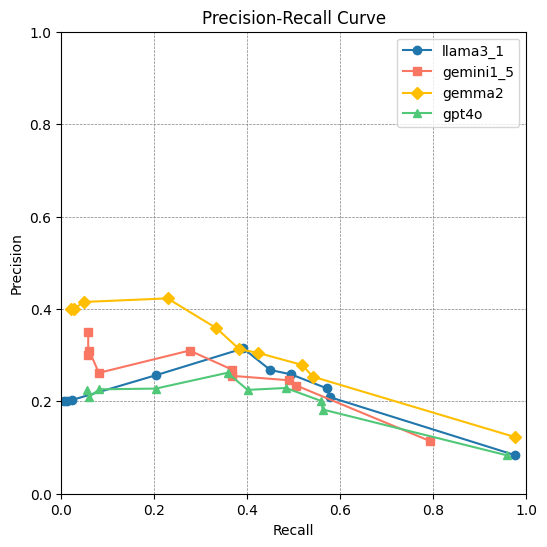

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for model in llm_res['model'].unique():
    model_scores = scores_df[scores_df['model'] == model]
    plt.plot(model_scores['recall'], model_scores['precision'], marker=['o', 's', 'D', '^'][list(llm_res['model'].unique()).index(model)], label=model, color=palette[list(llm_res['model'].unique()).index(model)])

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid( linestyle='--', linewidth=0.5, color='gray')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
